# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




### Connecting to Google Colab


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")



import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

# [1]. Reading Data

In [3]:

# using the SQLite Table to read data.
#con = sqlite3.connect('database.sqlite') 
con = sqlite3.connect('/content/drive/My Drive/Assignment 2 - tsne/database.sqlite') 
#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 5000""", con) 

# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (5000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [0]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [5]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [6]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [7]:
display['COUNT(*)'].sum()

393063

#  Exploratory Data Analysis

## [2] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [8]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As can be seen above the same user has multiple reviews of the with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text  and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [0]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [10]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(4986, 10)

In [11]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

99.72

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [12]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [0]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [14]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(4986, 10)


1    4178
0     808
Name: Score, dtype: int64

# [3].  Text Preprocessing.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [15]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

Why is this $[...] when the same product is available for $[...] here?<br />http://www.amazon.com/VICTOR-FLY-MAGNET-BAIT-REFILL/dp/B00004RBDY<br /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
I recently tried this flavor/brand and was surprised at how delicious these chips are.  The best thing was that there were a lot of "brown" chips in the bsg (my favorite), so I bought some more through amazon and shared with family and friends.  I am a little disappointed that there are not, so far, very many brown chips in these bags, but the flavor is still very good.  I like them better than the yogurt and green onion flavor because they do not seem to be as salty, and the onion flavor is better.  If you haven't eaten Kettle chips before, I recommend that you try a bag before buying bulk.  They are thicker and crunchier than Lays but just as fresh out of the bag.
Wow.  So far, two two-star reviews.  One obviously had no 

In [16]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [17]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

Why is this $[...] when the same product is available for $[...] here? />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
I recently tried this flavor/brand and was surprised at how delicious these chips are.  The best thing was that there were a lot of "brown" chips in the bsg (my favorite), so I bought some more through amazon and shared with family and friends.  I am a little disappointed that there are not, so far, very many brown chips in these bags, but the flavor is still very good.  I like them better than the yogurt and green onion flavor because they do not seem to be as salty, and the onion flavor is better.  If you haven't eaten Kettle chips before, I recommend that you try a bag before buying bulk.  They are thicker and crunchier than Lays but just as fresh out of the bag.
Wow.  So far, two two-star reviews.  One obviously had no idea what they were ordering; the other wants crispy cookies.  Hey, I'm sorry; b

In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [19]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Wow.  So far, two two-star reviews.  One obviously had no idea what they were ordering; the other wants crispy cookies.  Hey, I am sorry; but these reviews do nobody any good beyond reminding us to look  before ordering.<br /><br />These are chocolate-oatmeal cookies.  If you do not like that combination, do not order this type of cookie.  I find the combo quite nice, really.  The oatmeal sort of "calms" the rich chocolate flavor and gives the cookie sort of a coconut-type consistency.  Now let is also remember that tastes differ; so, I have given my opinion.<br /><br />Then, these are soft, chewy cookies -- as advertised.  They are not "crispy" cookies, or the blurb would say "crispy," rather than "chewy."  I happen to like raw cookie dough; however, I do not see where these taste like raw cookie dough.  Both are soft, however, so is this the confusion?  And, yes, they stick together.  Soft cookies tend to do that.  They are not individually wrapped, which would add to the cost.  Oh y

In [20]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor  and  traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [21]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Wow So far two two star reviews One obviously had no idea what they were ordering the other wants crispy cookies Hey I am sorry but these reviews do nobody any good beyond reminding us to look before ordering br br These are chocolate oatmeal cookies If you do not like that combination do not order this type of cookie I find the combo quite nice really The oatmeal sort of calms the rich chocolate flavor and gives the cookie sort of a coconut type consistency Now let is also remember that tastes differ so I have given my opinion br br Then these are soft chewy cookies as advertised They are not crispy cookies or the blurb would say crispy rather than chewy I happen to like raw cookie dough however I do not see where these taste like raw cookie dough Both are soft however so is this the confusion And yes they stick together Soft cookies tend to do that They are not individually wrapped which would add to the cost Oh yeah chocolate chip cookies tend to be somewhat sweet br br So if you wa

In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [23]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 4986/4986 [00:01<00:00, 3053.54it/s]


In [24]:
preprocessed_reviews[1500]

'wow far two two star reviews one obviously no idea ordering wants crispy cookies hey sorry reviews nobody good beyond reminding us look ordering chocolate oatmeal cookies not like combination not order type cookie find combo quite nice really oatmeal sort calms rich chocolate flavor gives cookie sort coconut type consistency let also remember tastes differ given opinion soft chewy cookies advertised not crispy cookies blurb would say crispy rather chewy happen like raw cookie dough however not see taste like raw cookie dough soft however confusion yes stick together soft cookies tend not individually wrapped would add cost oh yeah chocolate chip cookies tend somewhat sweet want something hard crisp suggest nabiso ginger snaps want cookie soft chewy tastes like combination chocolate oatmeal give try place second order'

<h2><font color='red'>[3.2] Preprocess Summary</font></h2>

In [25]:
## Similartly you can do preprocessing for review summary also.

# Refering from above
preprocessed_summary_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Summary'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_summary_reviews.append(sentance.strip())



100%|██████████| 4986/4986 [00:01<00:00, 4682.08it/s]


In [26]:
#Checking if our preprocessing for summary worked properly :

summary_1500 = final['Summary'].values[1500]
print("Original ==> ",summary_1500)
print("="*50)

print("After preprocessing ==> ",preprocessed_summary_reviews[1500])

Original ==>  Are We Reviewing Our Mistakes Or These Cookies?
After preprocessing ==>  reviewing mistakes cookies


# [4] Featurization

## [4.1] BAG OF WORDS

In [0]:
# Common Function for plotting TSNE Graph
def plot_TSNE_graph(title_of_graph, raw_data):
    
    final_score_df = final['Score']

    # creating a new data frame which help us in ploting the result data
    tsne_data = np.vstack((raw_data, final_score_df)).T
    tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

    # Ploting the result of tsne
    sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
    plt.title(title_of_graph)
    plt.show()

In [28]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'aahhhs', 'aback', 'abandon', 'abates', 'abbott', 'abby', 'abdominal', 'abiding', 'ability']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 12997)
the number of unique words  12997


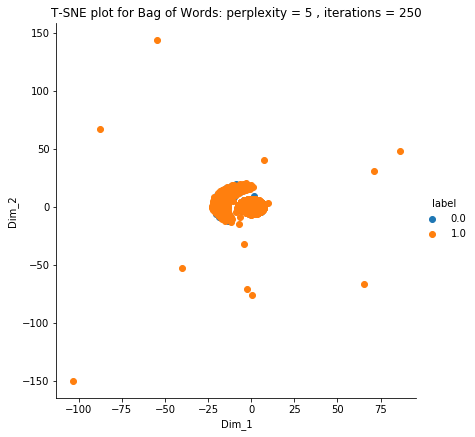

CPU times: user 11min 37s, sys: 668 ms, total: 11min 38s
Wall time: 11min 38s


In [29]:
%%time

# Data Standardization
final_counts = StandardScaler(with_mean=False).fit_transform(final_counts)

# Converting sparse matrix to dense matrix
final_counts = final_counts.todense()

# TSNE object creation using different perplexities and iterations
final_counts_tsne = TSNE(n_components=2,random_state=0,perplexity=5,n_iter=250)

# Generate model
tsne_bow = final_counts_tsne.fit_transform(final_counts)

# Plotting the TSNE graph for Bag-Of-Words
plot_TSNE_graph("T-SNE plot for Bag of Words: perplexity = 5 , iterations = 250",tsne_bow.T)

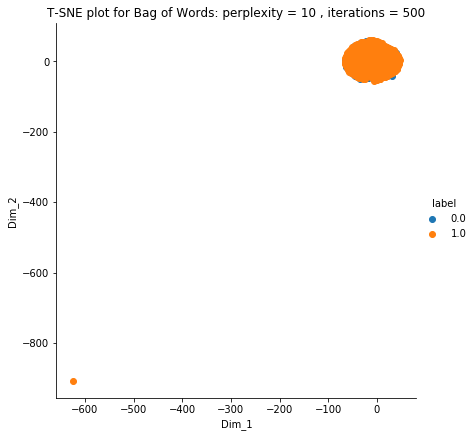

CPU times: user 11min 49s, sys: 495 ms, total: 11min 49s
Wall time: 11min 49s


In [30]:
%%time
#==============Second Iteration  for  BoW============================

# TSNE object creation using different perplexities and iterations
final_counts_tsne = TSNE(n_components=2,random_state=0,perplexity=10,n_iter=500)

# Generate model
tsne_bow = final_counts_tsne.fit_transform(final_counts)

# Plotting the TSNE graph for Bag-Of-Words
plot_TSNE_graph("T-SNE plot for Bag of Words: perplexity = 10 , iterations = 500",tsne_bow.T)

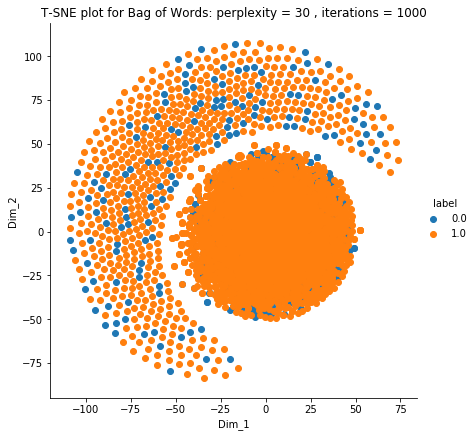

CPU times: user 12min 29s, sys: 660 ms, total: 12min 30s
Wall time: 12min 29s


In [31]:
%%time
#==============Third Iteration  for  BoW============================

# TSNE object creation using different perplexities and iterations
final_counts_tsne = TSNE(n_components=2,random_state=0,perplexity=30,n_iter=1000)

# Generate model
tsne_bow = final_counts_tsne.fit_transform(final_counts)

# Plotting the TSNE graph for Bag-Of-Words
plot_TSNE_graph("T-SNE plot for Bag of Words: perplexity = 30 , iterations = 1000",tsne_bow.T)

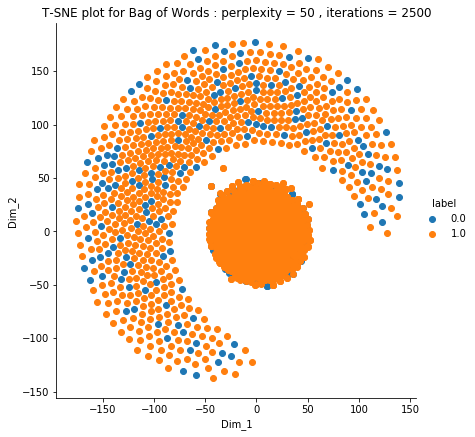

CPU times: user 14min 25s, sys: 774 ms, total: 14min 26s
Wall time: 14min 26s


In [32]:
%%time
#==============Fourth Iteration  for  BoW============================

# TSNE object creation using different perplexities and iterations
final_counts_tsne = TSNE(n_components=2,random_state=0,perplexity=50,n_iter=2500)

# Generate model
tsne_bow = final_counts_tsne.fit_transform(final_counts)

# Plotting the TSNE graph for Bag-Of-Words
plot_TSNE_graph("T-SNE plot for Bag of Words : perplexity = 50 , iterations = 2500",tsne_bow.T)

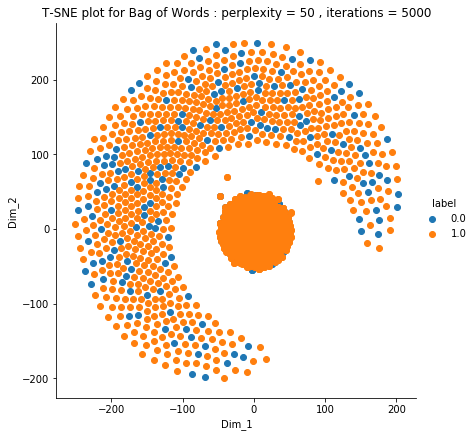

CPU times: user 17min 2s, sys: 1.4 s, total: 17min 3s
Wall time: 17min 3s


In [33]:
%%time
#==============Fourth Iteration  for  BoW============================

# TSNE object creation using different perplexities and iterations
final_counts_tsne = TSNE(n_components=2,random_state=0,perplexity=50,n_iter=5000)

# Generate model
tsne_bow = final_counts_tsne.fit_transform(final_counts)

# Plotting the TSNE graph for Bag-Of-Words
plot_TSNE_graph("T-SNE plot for Bag of Words : perplexity = 50 , iterations = 5000",tsne_bow.T)

## [4.2] Bi-Grams and n-Grams.

In [37]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


## [4.3] TF-IDF

In [38]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['ability', 'able', 'able find', 'able get', 'absolute', 'absolutely', 'absolutely delicious', 'absolutely love', 'absolutely no', 'according']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


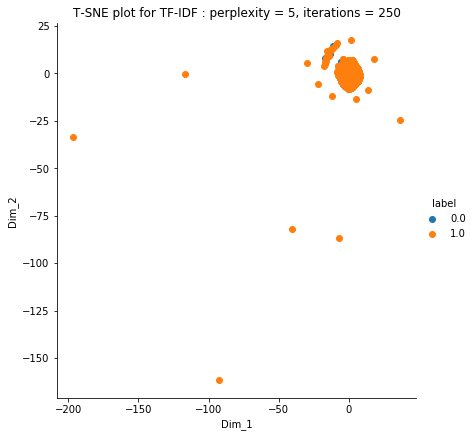

CPU times: user 2min 58s, sys: 343 ms, total: 2min 59s
Wall time: 2min 58s


In [39]:
#======== TSNE FOR TF-IDF======
%%time
#First Iteration

# Data Standardization
final_tf_idf = StandardScaler(with_mean=False).fit_transform(final_tf_idf)

# Converting sparse matrix to dense matrix
final_tf_idf = final_tf_idf.todense()

# TSNE object creation using different perplexities and iterations
final_tf_idf_tsne = TSNE(n_components=2,random_state=0,perplexity=5,n_iter=250)

# Generate model
tsne_tf_idf = final_tf_idf_tsne.fit_transform(final_tf_idf)

# Plotting the TSNE graph for TF-IDF
plot_TSNE_graph("T-SNE plot for TF-IDF : perplexity = 5, iterations = 250",tsne_tf_idf.T)

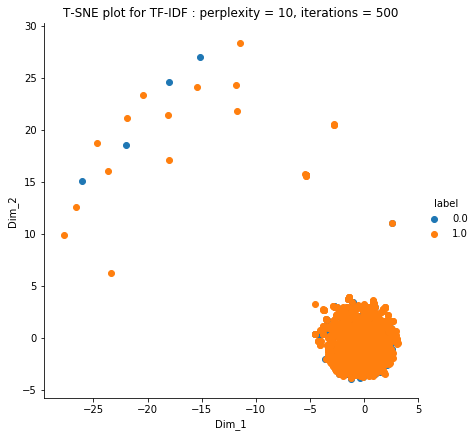

CPU times: user 3min 9s, sys: 386 ms, total: 3min 9s
Wall time: 3min 9s


In [40]:
%%time
#==============Second Iteration  for  TF-IDF============================

# TSNE object creation using different perplexities and iterations
final_tf_idf_tsne = TSNE(n_components=2,random_state=0,perplexity=10,n_iter=500)

# Generate model
tsne_tf_idf = final_tf_idf_tsne.fit_transform(final_tf_idf)

# Plotting the TSNE graph for TF-IDF
plot_TSNE_graph("T-SNE plot for TF-IDF : perplexity = 10, iterations = 500",tsne_tf_idf.T)

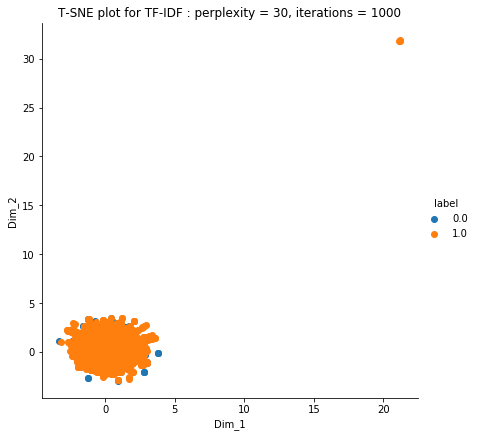

CPU times: user 3min 51s, sys: 399 ms, total: 3min 51s
Wall time: 3min 51s


In [41]:
%%time
#==============Third Iteration  for  TF-IDF============================

# TSNE object creation using different perplexities and iterations
final_tf_idf_tsne = TSNE(n_components=2,random_state=0,perplexity=30,n_iter=1000)

# Generate model
tsne_tf_idf = final_tf_idf_tsne.fit_transform(final_tf_idf)

# Plotting the TSNE graph for TF-IDF
plot_TSNE_graph("T-SNE plot for TF-IDF : perplexity = 30, iterations = 1000",tsne_tf_idf.T)

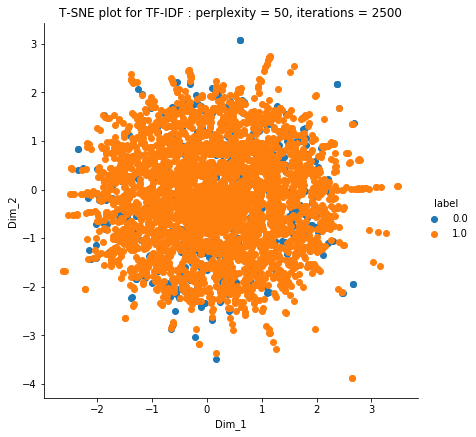

CPU times: user 5min 30s, sys: 791 ms, total: 5min 31s
Wall time: 5min 31s


In [42]:
%%time
#==============Fourth Iteration  for  TF-IDF============================

# TSNE object creation using different perplexities and iterations
final_tf_idf_tsne = TSNE(n_components=2,random_state=0,perplexity=50,n_iter=2500)

# Generate model
tsne_tf_idf = final_tf_idf_tsne.fit_transform(final_tf_idf)

# Plotting the TSNE graph for TF-IDF
plot_TSNE_graph("T-SNE plot for TF-IDF : perplexity = 50, iterations = 2500",tsne_tf_idf.T)

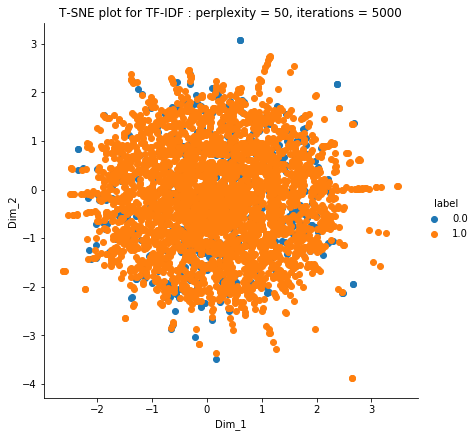

CPU times: user 5min 28s, sys: 1.03 s, total: 5min 29s
Wall time: 5min 29s


In [43]:
%%time
#==============Fifth Iteration  for  TF-IDF============================

# TSNE object creation using different perplexities and iterations
final_tf_idf_tsne = TSNE(n_components=2,random_state=0,perplexity=50,n_iter=5000)

# Generate model
tsne_tf_idf = final_tf_idf_tsne.fit_transform(final_tf_idf)

# Plotting the TSNE graph for TF-IDF
plot_TSNE_graph("T-SNE plot for TF-IDF : perplexity = 50, iterations = 5000",tsne_tf_idf.T)

## [4.4] Word2Vec

In [0]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [45]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('snack', 0.9965299963951111), ('tasty', 0.9959202408790588), ('feel', 0.9953665733337402), ('alternative', 0.9953479766845703), ('salty', 0.9953451156616211), ('buds', 0.9950718283653259), ('crunch', 0.9947696924209595), ('licorice', 0.9947300553321838), ('think', 0.9945217967033386), ('satisfying', 0.9945076107978821)]
[('perhaps', 0.9995313286781311), ('hands', 0.9995183944702148), ('become', 0.9994621872901917), ('opinion', 0.9994590282440186), ('beans', 0.9994350075721741), ('completely', 0.9994295239448547), ('part', 0.9994187951087952), ('chewing', 0.9994174242019653), ('standard', 0.9994140863418579), ('beef', 0.999412477016449)]


In [46]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  3817
sample words  ['product', 'available', 'course', 'total', 'pretty', 'stinky', 'right', 'nearby', 'used', 'ca', 'not', 'beat', 'great', 'received', 'shipment', 'could', 'hardly', 'wait', 'try', 'love', 'call', 'instead', 'removed', 'easily', 'daughter', 'designed', 'printed', 'use', 'car', 'windows', 'beautifully', 'shop', 'program', 'going', 'lot', 'fun', 'everywhere', 'like', 'tv', 'computer', 'really', 'good', 'idea', 'final', 'outstanding', 'window', 'everybody', 'asks', 'bought', 'made']


## [4.4.1] Converting text into vectors using wAvg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [47]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|██████████| 4986/4986 [00:03<00:00, 1333.44it/s]

4986
50


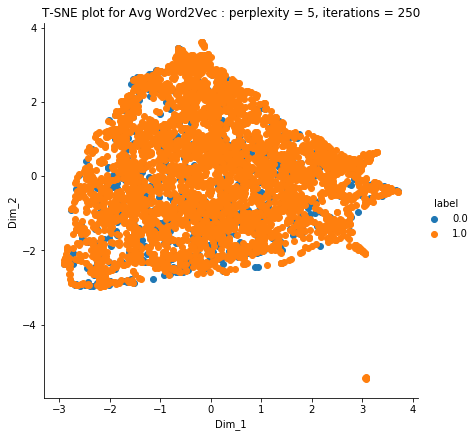

CPU times: user 10.8 s, sys: 298 ms, total: 11.1 s
Wall time: 10.7 s


In [48]:
%%time
#========================TSNE FOR AVERAGE-WORD2VEC =======================
# Data Standardization
avg_w2v_model = StandardScaler().fit_transform(sent_vectors)


# TSNE object creation using different perplexities and iterations
avg_w2v_model_tsne = TSNE(n_components=2,random_state=0,perplexity=5,n_iter=250)

# Generate model
tsne_avg_w2v = avg_w2v_model_tsne.fit_transform(avg_w2v_model)

# Plotting the TSNE graph for Average Word2Vec
plot_TSNE_graph("T-SNE plot for Avg Word2Vec : perplexity = 5, iterations = 250",tsne_avg_w2v.T)

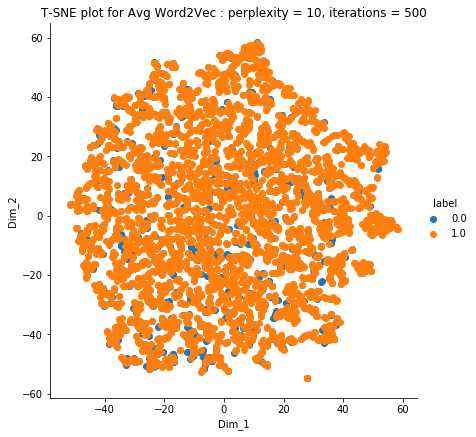

CPU times: user 18.6 s, sys: 432 ms, total: 19 s
Wall time: 18.6 s


In [49]:
%%time
#========================Second iterations for AVERAGE-WORD2VEC =======================

# TSNE object creation using different perplexities and iterations
avg_w2v_model_tsne = TSNE(n_components=2,random_state=0,perplexity=10,n_iter=500)

# Generate model
tsne_avg_w2v = avg_w2v_model_tsne.fit_transform(avg_w2v_model)

# Plotting the TSNE graph for Average Word2Vec
plot_TSNE_graph("T-SNE plot for Avg Word2Vec : perplexity = 10, iterations = 500",tsne_avg_w2v.T)

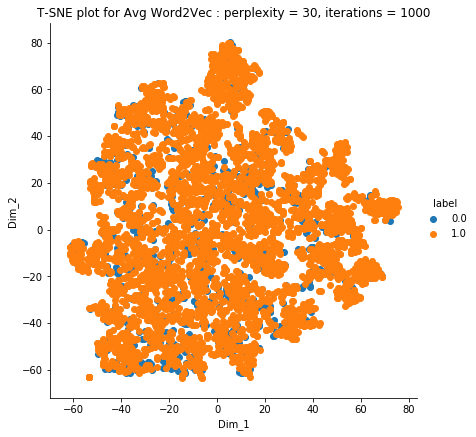

CPU times: user 37.1 s, sys: 429 ms, total: 37.5 s
Wall time: 37.2 s


In [50]:
%%time
#========================Third iterations for AVERAGE-WORD2VEC =======================

# TSNE object creation using different perplexities and iterations
avg_w2v_model_tsne = TSNE(n_components=2,random_state=0,perplexity=30,n_iter=1000)

# Generate model
tsne_avg_w2v = avg_w2v_model_tsne.fit_transform(avg_w2v_model)

# Plotting the TSNE graph for Average Word2Vec
plot_TSNE_graph("T-SNE plot for Avg Word2Vec : perplexity = 30, iterations = 1000",tsne_avg_w2v.T)

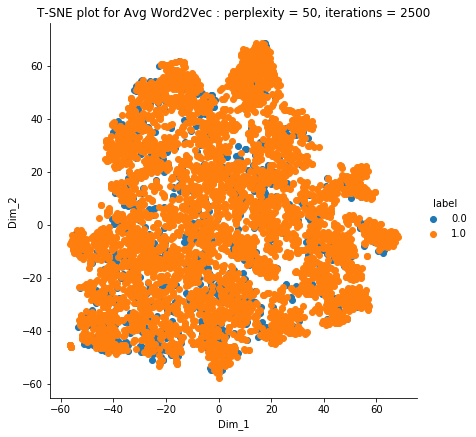

CPU times: user 1min 39s, sys: 673 ms, total: 1min 39s
Wall time: 1min 39s


In [51]:
%%time
#========================Fourth iterations for AVERAGE-WORD2VEC =======================

# TSNE object creation using different perplexities and iterations
avg_w2v_model_tsne = TSNE(n_components=2,random_state=0,perplexity=50,n_iter=2500)

# Generate model
tsne_avg_w2v = avg_w2v_model_tsne.fit_transform(avg_w2v_model)

# Plotting the TSNE graph for Average Word2Vec
plot_TSNE_graph("T-SNE plot for Avg Word2Vec : perplexity = 50, iterations = 2500",tsne_avg_w2v.T)

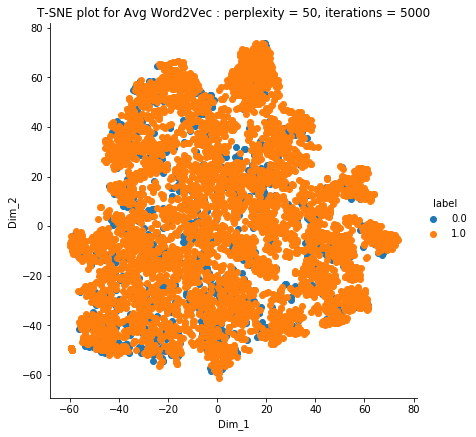

CPU times: user 3min 15s, sys: 1.04 s, total: 3min 16s
Wall time: 3min 16s


In [52]:
%%time
#========================Fifth iterations for AVERAGE-WORD2VEC =======================

# TSNE object creation using different perplexities and iterations
avg_w2v_model_tsne = TSNE(n_components=2,random_state=0,perplexity=50,n_iter=5000)

# Generate model
tsne_avg_w2v = avg_w2v_model_tsne.fit_transform(avg_w2v_model)

# Plotting the TSNE graph for Average Word2Vec
plot_TSNE_graph("T-SNE plot for Avg Word2Vec : perplexity = 50, iterations = 5000",tsne_avg_w2v.T)

#### [4.4.1.2] TFIDF weighted W2v

In [0]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
model.fit(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [54]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 4986/4986 [00:29<00:00, 170.34it/s]


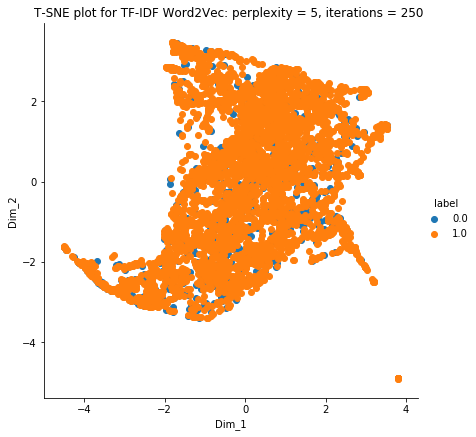

CPU times: user 10.4 s, sys: 348 ms, total: 10.8 s
Wall time: 10.4 s


In [62]:
%%time
#====================TSNE for TF-IDF-WORD2VEC ==============================

# first Iteration

# Data Standardization
tfidfw2v_model = StandardScaler().fit_transform(tfidf_sent_vectors)

# TSNE object creation using different perplexities and iterations
tfidfw2v_model_tsne = TSNE(n_components=2,random_state=0,perplexity=5,n_iter=250)

# Generate model
tsne_tfidfw2v = tfidfw2v_model_tsne.fit_transform(tfidfw2v_model)

# Plotting the TSNE graph for TF-IDF Word2Vec
plot_TSNE_graph("T-SNE plot for TF-IDF Word2Vec: perplexity = 5, iterations = 250 ",tsne_tfidfw2v.T)

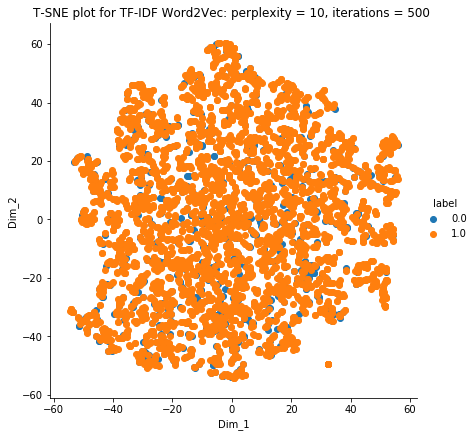

CPU times: user 18.3 s, sys: 434 ms, total: 18.7 s
Wall time: 18.4 s


In [63]:
%%time
#====================Second Iteration for TF-IDF-WORD2VEC ==============================

# TSNE object creation using different perplexities and iterations
tfidfw2v_model_tsne = TSNE(n_components=2,random_state=0,perplexity=10,n_iter=500)

# Generate model
tsne_tfidfw2v = tfidfw2v_model_tsne.fit_transform(tfidfw2v_model)

# Plotting the TSNE graph for TF-IDF Word2Vec
plot_TSNE_graph("T-SNE plot for TF-IDF Word2Vec: perplexity = 10, iterations = 500 ",tsne_tfidfw2v.T)

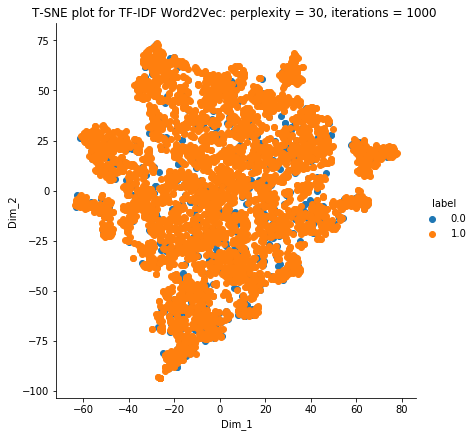

CPU times: user 39.7 s, sys: 419 ms, total: 40.1 s
Wall time: 39.8 s


In [64]:
%%time
#====================Third Iteration for TF-IDF-WORD2VEC ==============================

# TSNE object creation using different perplexities and iterations
tfidfw2v_model_tsne = TSNE(n_components=2,random_state=0,perplexity=30,n_iter=1000)

# Generate model
tsne_tfidfw2v = tfidfw2v_model_tsne.fit_transform(tfidfw2v_model)

# Plotting the TSNE graph for TF-IDF Word2Vec
plot_TSNE_graph("T-SNE plot for TF-IDF Word2Vec: perplexity = 30, iterations = 1000 ",tsne_tfidfw2v.T)

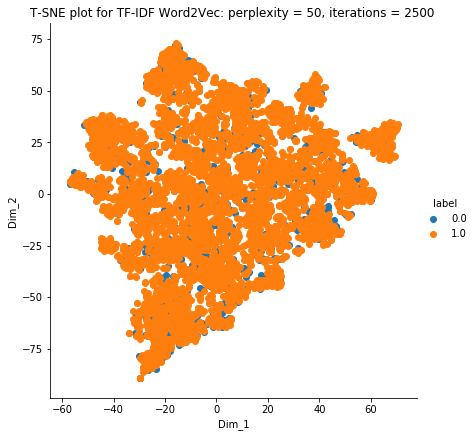

CPU times: user 1min 50s, sys: 752 ms, total: 1min 51s
Wall time: 1min 51s


In [65]:
%%time
#====================Fourth Iteration for TF-IDF-WORD2VEC ==============================

# TSNE object creation using different perplexities and iterations
tfidfw2v_model_tsne = TSNE(n_components=2,random_state=0,perplexity=50,n_iter=2500)

# Generate model
tsne_tfidfw2v = tfidfw2v_model_tsne.fit_transform(tfidfw2v_model)

# Plotting the TSNE graph for TF-IDF Word2Vec
plot_TSNE_graph("T-SNE plot for TF-IDF Word2Vec: perplexity = 50, iterations = 2500 ",tsne_tfidfw2v.T)

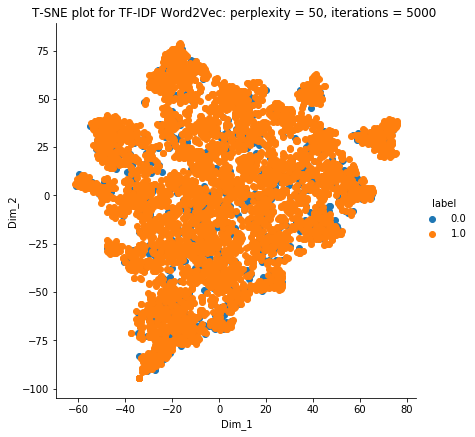

CPU times: user 3min 39s, sys: 1.22 s, total: 3min 41s
Wall time: 3min 40s


In [66]:
%%time
#====================Fifth Iteration for TF-IDF-WORD2VEC ==============================

# TSNE object creation using different perplexities and iterations
tfidfw2v_model_tsne = TSNE(n_components=2,random_state=0,perplexity=50,n_iter=5000)

# Generate model
tsne_tfidfw2v = tfidfw2v_model_tsne.fit_transform(tfidfw2v_model)

# Plotting the TSNE graph for TF-IDF Word2Vec
plot_TSNE_graph("T-SNE plot for TF-IDF Word2Vec: perplexity = 50, iterations = 5000 ",tsne_tfidfw2v.T)

### Conclusions : 

1. We have successfully applied Dimentionality Reduction technique, TSNE to different models like Bag of Words, TF-IDF, Average Word2vec , TF-IDF Word2Vec with various perplexities and iterations.

2. The positive and negative reviews overlaps each other in all of the above mention models.

3. Seperation of positive and negative revies is not posible using TSNE, some other methodology must be applied.